In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix

In [ ]:
print  ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print(tf.config.list_physical_devices)

<function list_physical_devices at 0x7f980cc417a0>


In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3246299880872105077
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9445086449719640414
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test = pd.read_csv("drive/MyDrive/updated_fakes.csv")
test.columns
test.head()

,unit_id,article_title,article_content,source,date,location,labels,URL
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0,http://nna-leb.gov.lb/en/show-news/77705/
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0,http://nna-leb.gov.lb/en/show-news/65189/nna-l...


In [ ]:
test['labels'].value_counts()

1    426
0    378
Name: labels, dtype: int64

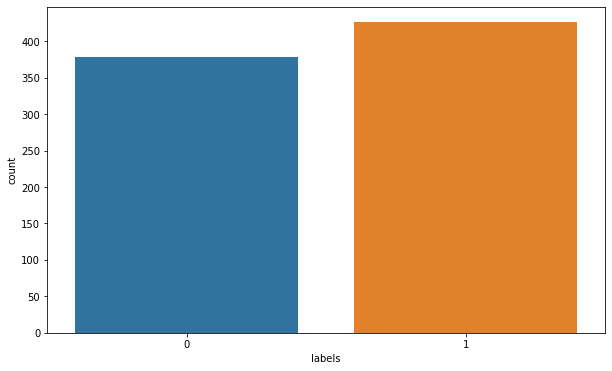

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='labels', data=test)

In [ ]:
test['article_content'] = test['article_content'].apply(lambda x: str(x).lower())

In [ ]:
test = test[['article_content', 'labels']]

In [ ]:
test['labels'] = test['labels'].astype(float)

In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

     |████████████████████████████████| 10.4 MB 9.0 MB/s 
     |████████████████████████████████| 2.2 MB 40.4 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 12.0 MB 825 kB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 115 kB 11.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-jyvnx9h0
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pi

In [ ]:
import preprocess_kgptalkie as ps

In [ ]:
test['article_content'] = test['article_content'].apply(lambda x: ps.remove_special_chars(x))

In [ ]:
x = [d.split() for d in test['article_content'].tolist()]
y = test['labels'].values

In [ ]:
pip install imbalanced-learn

In [ ]:
print(len(x))

804


In [ ]:
DIM = 400
w2v_model = gensim.models.Word2Vec(sentences=x, size=DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.vocab)

11007

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(x)

In [ ]:
x = tokenizer.texts_to_sequences(x)

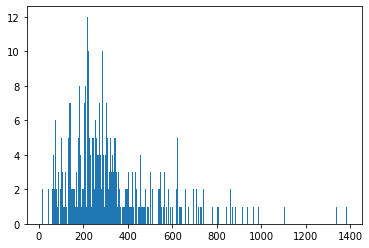

In [ ]:
plt.hist([len(a) for a in x], bins = 700)
plt.show()

In [ ]:
nos = np.array([len(a) for a in x])
len(nos[nos>1000])

4

In [ ]:
maxlen = 100
x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items():
        try:
            weight_matrix[i] = model.wv[word]
        except:
            print("whatever")
        
    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
embedding_vectors.shape

(11008, 400)

In [ ]:
maxlen

100

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size, output_dim=DIM, weights=[embedding_vectors], input_length=maxlen, trainable = False))
model.add(Conv1D(128, 5, activation="relu", input_dim=100))
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid")) 
model.add(LSTM(32))
model.add(Dense(2, activation = 'sigmoid')) 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
    optimizer = "Adam",               
              metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 400)          4403200   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           256128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 4,680,002
Trainable params: 276,802
Non-trainable params: 4,403,200
________________________________________

In [ ]:
len(x)

804

In [ ]:
CNNRNNX_train, CNNRNNX_test, CNNRNNy_train, CNNRNNy_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# [1, 0] is false [0, 1] is true
CNNRNNy_train = [[1,0] if x==0.0 else [0,1] if x==1.0 else x for x in CNNRNNy_train]
CNNRNNy_test = [[1,0] if x==0.0 else [0,1] if x==1.0 else x for x in CNNRNNy_test]

In [ ]:
CNNRNNy_train = np.array(CNNRNNy_train)
CNNRNNy_test = np.array(CNNRNNy_test)

In [ ]:
model.fit(CNNRNNX_train, CNNRNNy_train, epochs=10, batch_size=64)

Epoch 1/10
11/11 [==============================] - 12s 25ms/step - loss: 0.7048 - accuracy: 0.4961 - recall: 0.5194 - precision: 0.5015 - true_negatives: 311.0000 - true_positives: 334.0000 - false_positives: 332.0000 - false_negatives: 309.0000
Epoch 2/10
11/11 [==============================] - 0s 23ms/step - loss: 0.6831 - accuracy: 0.5910 - recall: 0.5925 - precision: 0.5808 - true_negatives: 368.0000 - true_positives: 381.0000 - false_positives: 275.0000 - false_negatives: 262.0000
Epoch 3/10
11/11 [==============================] - 0s 22ms/step - loss: 0.6822 - accuracy: 0.5521 - recall: 0.5925 - precision: 0.5397 - true_negatives: 318.0000 - true_positives: 381.0000 - false_positives: 325.0000 - false_negatives: 262.0000
Epoch 4/10
11/11 [==============================] - 0s 22ms/step - loss: 0.6778 - accuracy: 0.5801 - recall: 0.5505 - precision: 0.5710 - true_negatives: 377.0000 - true_positives: 354.0000 - false_positives: 266.0000 - false_negatives: 289.0000
Epoch 5/10
11/1

In [ ]:
model.evaluate(CNNRNNX_test, CNNRNNy_test)

6/6 [==============================] - 1s 13ms/step - loss: 0.7155 - accuracy: 0.4845 - recall: 0.5155 - precision: 0.4940 - true_negatives: 76.0000 - true_positives: 83.0000 - false_positives: 85.0000 - false_negatives: 78.0000


[0.7154570817947388,
 0.48447203636169434,
 0.5155279636383057,
 0.494047611951828,
 76.0,
 83.0,
 85.0,
 78.0]

In [ ]:
!pip install whois
!pip install pyquery
!pip install tqdm
!pip install interruptingcow
!pip install requests

  Created wheel for whois: filename=whois-0.9.13-py3-none-any.whl size=9609 sha256=b344adf57bb07b26d4b0330f6e7545ae0c47104dd76d3d00a3b156b05d884400
  Stored in directory: /root/.cache/pip/wheels/f5/85/a6/2ac688355ea1a85b0a2b9c0243012f3021333b6c65b7305d86
Successfully built whois
  Created wheel for interruptingcow: filename=interruptingcow-0.8-py3-none-any.whl size=5825 sha256=21183e05def64a8813893666feb06cd5a5d7e58f85fdf3eaa4084984b878412e
  Stored in directory: /root/.cache/pip/wheels/fe/83/45/99297454c39c203890ab65c08db879940862778921cc61a416
Successfully built interruptingcow


In [ ]:
import requests
from interruptingcow import timeout
import whois
from datetime import datetime, timezone
import math
import pandas as pd
import numpy as np
from pyquery import PyQuery
from requests import get
import tensorflow as tf
import keras
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from numpy import unique
from tensorflow.keras import layers
from tensorflow.math import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    ## URL string Features
    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/updated_fakes.csv', names = ['id', 'title', 'content', 'source', 'date', 'location', 'rating', 'url'])
data.head(5)

,id,title,content,source,date,location,rating,url
0,unit_id,article_title,article_content,source,date,location,labels,URL
1,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0,http://nna-leb.gov.lb/en/show-news/77705/
2,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
3,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
4,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...


In [ ]:
data = data.drop(columns = ["source", "date", "location", "title", "content", "id"])
data = data.drop(data.index[0])

data.head(5)

,rating,url
1,0,http://nna-leb.gov.lb/en/show-news/77705/
2,0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
3,0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
4,0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...
5,0,http://nna-leb.gov.lb/en/show-news/65189/nna-l...


In [ ]:
data['rating'].value_counts()
data['rating'] = data['rating'].astype(float)

In [ ]:
data.head(5)

,rating,url
1,0.0,http://nna-leb.gov.lb/en/show-news/77705/
2,0.0,http://nna-leb.gov.lb/en/show-news/77731/nna-l...
3,0.0,http://nna-leb.gov.lb/en/show-news/29474/nna-l...
4,0.0,http://nna-leb.gov.lb/en/show-news/78274/nna-l...
5,0.0,http://nna-leb.gov.lb/en/show-news/65189/nna-l...


In [ ]:
features_list = []
for idx, row in data.iterrows():
  url_string = row['url']
  rating = row['rating']
  features = UrlFeaturizer(url_string).run()
  features['rating'] = rating
  features_list.append(features)

df = pd.DataFrame(features_list)

Unknown TLD: .lb
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za Unknown TLD: .lb
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se

In [ ]:
df

,entropy,numDigits,urlLength,numParams,hasHttp,hasHttps,urlIsLive,bodyLength,numTitles,numImages,numLinks,scriptLength,specialChars,ext,dsr,dse,sscr,sbr,bscr,num_%20,num_@,has_ip,rating
0,-4.113173,5,41,0,True,False,False,4661,5,0,2,2967,1097,lb,0,0,2.704649,0.636559,0.235357,0,0,0,0.0
1,-4.055393,5,73,0,True,False,False,4705,5,0,2,3011,1097,lb,0,0,2.744758,0.639957,0.233156,0,0,0,0.0
2,-4.171736,5,55,0,True,False,False,4682,5,0,2,2988,1094,lb,0,0,2.731261,0.638189,0.233661,0,0,0,0.0
3,-4.126561,5,58,0,True,False,False,4686,5,0,2,2992,1097,lb,0,0,2.727438,0.638498,0.234102,0,0,0,0.0
4,-4.096221,5,73,0,True,False,False,4712,5,0,2,3012,1091,lb,0,0,2.760770,0.639219,0.231537,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,-4.469354,6,59,0,True,False,False,2648,2,3,18,834,598,php?id=283853,0,0,1.394649,0.314955,0.225831,0,0,0,1.0
800,-4.469354,6,59,0,True,False,False,1919,2,3,18,834,454,php?id=282445,0,0,1.837004,0.434601,0.236582,0,0,0,1.0
801,-4.503252,6,59,0,True,False,False,2612,2,3,18,834,573,php?id=280817,0,0,1.455497,0.319296,0.219372,0,0,0,0.0
802,-4.537150,6,59,0,True,False,False,2691,2,3,18,834,603,php?id=280641,0,0,1.383085,0.309922,0.224080,0,0,0,1.0


In [ ]:
df.replace(True,1,inplace = True)    
df.replace(False,0,inplace = True)

df.ext = pd.Categorical(df.ext).codes
print(df.ext.head(5))

y = df['rating'] 
encoder = LabelEncoder()    
encoder.fit(y)    
Y = encoder.transform(y)  
scaler = MinMaxScaler(feature_range=(0, 1))    

X = pd.DataFrame(scaler.fit_transform(df))


0    4
1    4
2    4
3    4
4    4
Name: ext, dtype: int8


In [ ]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,

In [ ]:
URLX_train, URLX_test, URLy_train, URLy_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from keras.utils.np_utils import to_categorical
URLy_test = to_categorical(URLy_test)
URLy_train = to_categorical(URLy_train)

In [ ]:
from keras.engine.input_layer import InputLayer

model2 = Sequential()    
model2.add(InputLayer(23))
model2.add(Dense(256, input_dim = 23 , activation = 'relu'))    
model2.add(Dense(128, activation = 'relu'))    
model2.add(Dense(64, activation = 'relu'))    
model2.add(Dense(32, activation = 'relu'))    
model2.add(Dense(16, activation = 'relu'))    
model2.add(Dense(2, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy' ,optimizer='adam' , metrics = ['accuracy', 'Recall', 'Precision', 'TrueNegatives', 'TruePositives', 'FalsePositives', 'FalseNegatives'] )

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 256)               6144      
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 2)                 34        
                                                                 
Total params: 49,938
Trainable params: 49,938
Non-trai

In [ ]:
model2.fit(URLX_train, URLy_train, epochs = 10) 

Epoch 1/10
21/21 [==============================] - 2s 8ms/step - loss: 0.4820 - accuracy: 0.9720 - recall: 0.9720 - precision: 0.9720 - true_negatives: 625.0000 - true_positives: 625.0000 - false_positives: 18.0000 - false_negatives: 18.0000
Epoch 2/10
21/21 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - true_negatives: 643.0000 - true_positives: 643.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 3/10
21/21 [==============================] - 0s 7ms/step - loss: 7.8475e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - true_negatives: 643.0000 - true_positives: 643.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Epoch 4/10
21/21 [==============================] - 0s 7ms/step - loss: 2.1895e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - true_negatives: 643.0000 - true_positives: 643.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00
Ep

In [ ]:
model2.evaluate(URLX_test, URLy_test)

6/6 [==============================] - 1s 9ms/step - loss: 3.4246e-05 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - true_negatives: 161.0000 - true_positives: 161.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00


[3.424589885980822e-05, 1.0, 1.0, 1.0, 161.0, 161.0, 0.0, 0.0]

In [ ]:
CNNRNNaccuracy = {}

CNNRNNaccuracy['model'] = model.evaluate(
    CNNRNNX_test, CNNRNNy_test, verbose=0)

CNNRNNaccuracy = CNNRNNaccuracy['model'][1]

In [ ]:
URLaccuracy = {}

URLaccuracy['model'] = model2.evaluate(
    URLX_test, URLy_test, verbose=0)

URLaccuracy = URLaccuracy['model'][1]

In [ ]:
CNNRNNweight = CNNRNNaccuracy / (CNNRNNaccuracy + URLaccuracy)
URLweight = URLaccuracy / (CNNRNNaccuracy + URLaccuracy)

print(CNNRNNweight, URLweight)

0.32635982658797075 0.6736401734120293


In [ ]:
CNNRNNpredictions = model.predict(CNNRNNX_test)

In [ ]:
URLpredictions = model2.predict(URLX_test)

In [ ]:
for x in range(len(CNNRNNpredictions)):
  CNNRNNpredictions[x] = [CNNRNNpredictions[x][0]*CNNRNNweight, CNNRNNpredictions[x][1]*CNNRNNweight]

In [ ]:
for x in range(len(URLpredictions)):
  URLpredictions[x] = [URLpredictions[x][0]*URLweight, URLpredictions[x][1]*URLweight]

In [ ]:
combinedResultArray = []
for x in range(len(CNNRNNpredictions)):
  combinedResultArray.append([CNNRNNpredictions[x][0]+URLpredictions[x][0], URLpredictions[x][1]+URLpredictions[x][1]])

In [ ]:
for x in range(len(combinedResultArray)):
  if combinedResultArray[x][0] > combinedResultArray[x][1]:
    combinedResultArray[x] = [1, 0]
  else:
    combinedResultArray[x] = [0, 1]

In [ ]:
for x in range(len(combinedResultArray)):
  if combinedResultArray[x] == [1, 0]:
    combinedResultArray[x] = True
  else:
    combinedResultArray[x] = False

In [ ]:
for x in range(len(combinedResultArray)):
  print("The " + str(x + 1) + "st/nd/th article is most likely: " + str(combinedResultArray[x]))

The 1st/nd/th article is most likely: False
The 2st/nd/th article is most likely: False
The 3st/nd/th article is most likely: False
The 4st/nd/th article is most likely: True
The 5st/nd/th article is most likely: False
The 6st/nd/th article is most likely: True
The 7st/nd/th article is most likely: True
The 8st/nd/th article is most likely: True
The 9st/nd/th article is most likely: True
The 10st/nd/th article is most likely: True
The 11st/nd/th article is most likely: True
The 12st/nd/th article is most likely: False
The 13st/nd/th article is most likely: False
The 14st/nd/th article is most likely: False
The 15st/nd/th article is most likely: False
The 16st/nd/th article is most likely: True
The 17st/nd/th article is most likely: True
The 18st/nd/th article is most likely: False
The 19st/nd/th article is most likely: False
The 20st/nd/th article is most likely: True
The 21st/nd/th article is most likely: False
The 22st/nd/th article is most likely: True
The 23st/nd/th article is most

# Inputting Singular URLs

In [ ]:
features_list = []
for idx, row in data.iterrows():
  print(idx, row)
  url_string = row['url']
  rating = row['rating']
  features = UrlFeaturizer(url_string).run()
  features['rating'] = rating
  features_list.append(features)

URLdf = pd.DataFrame(features_list)
X = pd.DataFrame(scaler.fit_transform(URLdf))

1 rating                                            0
url       http://nna-leb.gov.lb/en/show-news/77705/
Name: 1, dtype: object
Unknown TLD: .lb
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .download .edu .education .eu .fi .fm .fr .frl .game .global_ .hk .id_ .ie .im .in_ .info .ink .io .ir .is_ .it .jp .kr .kz .link .lt .lv .me .mobi .mu .mx .name .net .ninja .nl .nu .nyc .nz .online .org .pe .pharmacy .pl .press .pro .pt .pub .pw .rest .ru .ru_rf .rw .sale .se .security .sh .site .space .store .tech .tel .theatre .tickets .trade .tv .ua .uk .us .uz .video .website .wiki .work .xyz .za 2 rating                                                    0
url       http://nna-leb.gov.lb/en/show-news/77731/nna-l...
Name: 2, dtype: object
Unknown TLD: .lb
Valid TLDs: .ac_uk .am .amsterdam .ar .at .au .bank .be .biz .br .by .ca .cc .cl .club .cn .co .co_il .co_jp .com .com_au .com_tr .cr .cz .de .do

ValueError: ignored